# **1. Basics**
**Prerequisites**

`pytorch`, `torchvision`, `numpy`, `openCV2`,`matplotlib`

In [3]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For utilities
import time, sys, os
sys.path.insert(0, '../src')

# For conversion
import cv2
import opencv_transforms.transforms as TF
import opencv_transforms.functional as FF
import dataloader

# For everything
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.autograd import Variable
import random

# For our model
from model import models

# To ignore warning
import warnings
warnings.simplefilter("ignore", UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    print("The gpu to be used : {}".format(torch.cuda.get_device_name(0)))
else:
    print("No gpu detected")

The gpu to be used : GeForce GTX 1060 6GB


# **1. Loading dataset**

## 1.1 Color to sketch converter

The `netC2S` is a network that convert a colorful image to sketch image. The network was pretrained on the dataset [1]. Even though there are some other methods to convert image to sketch like edge detection, Just forwarding another pretrained network is faster and gives better result.

To load the model weights, download the checkpoint on https://drive.google.com/open?id=1pIZCjubtyOUr7AXtGQMvzcbKczJ9CtQG (449MB) and unzip on directory `../src/model/checkpoint`. 
Then the file on `../src/model/checkpoint/color2sketch.pth` will be loaded.

[1] Taebum Kim, "Anime Sketch Colorization Pair", https://www.kaggle.com/ktaebum/anime-sketch-colorization-pair, 2019., 2020.1.13.

In [5]:
with torch.no_grad():
    netC2S = models.Color2Sketch(norm='IN', 
                                 SN=True, 
                                 activation='relu', 
                                 residual=False, 
                                 ckpt_path='../src/model/checkpoint/color2sketch.pth').to(device)
    netC2S.eval()

## 1.2 Custom Dataloader

To pre-process input images, the module `opencv_transforms.transforms` and `opencv_transforms.functional` are used.[2] These are implemented with **openCV** so much faster than `torchvision.transforms` which is based on **Pillow**.

To download dataset used to train, go [1] and download. Unzip the images.

[2] Jim Bohnslav,"opencv_transforms", https://github.com/jbohnslav/opencv_transforms, 2020.1.13.

In [28]:
# batch_size
batch_size = 2

# Training data
print('Loading Training data...', end=' ')
train_transforms = TF.Compose([
    TF.RandomResizedCrop(512, interpolation=cv2.INTER_AREA),
    TF.RandomHorizontalFlip(),
    ])

train_imagefolder = dataloader.GetImageFolder('../../dataset/a/illust2/imgs', 
                                              train_transforms, 
                                              start='Edge',
                                              end='RGB',
                                              hint='Scribbles',
                                              sketch_net=netC2S)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=batch_size, shuffle=True)
print("Done!")
print("Training data size : {}".format(len(train_imagefolder)))
train_batch = next(iter(train_loader))

Loading Training data... Done!
Training data size : 68659


## 1.3 Dataset Test

Check the dataset.

In [29]:
temp_batch_iter = iter(train_loader)

torch.Size([2, 1, 512, 512])
tensor(0.8600)


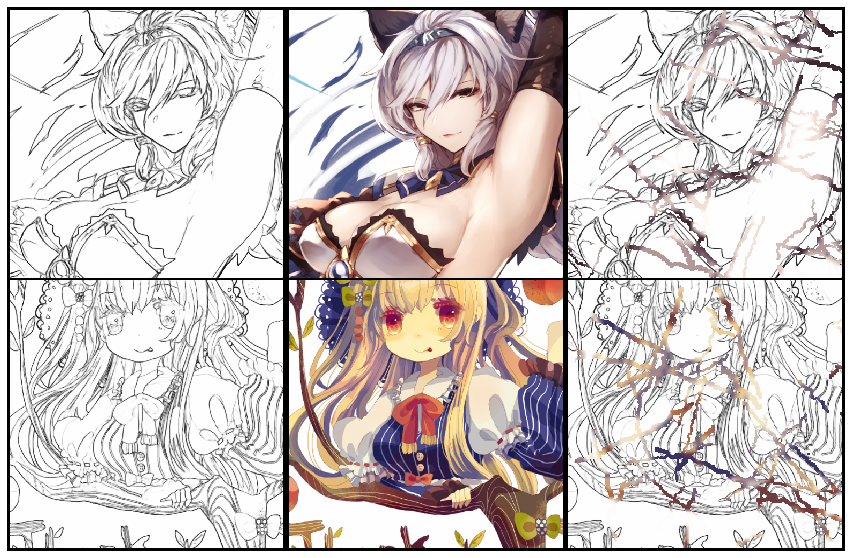

In [30]:
temp_batch = next(temp_batch_iter)
gray = temp_batch[0]
color = temp_batch[1]
hint = temp_batch[2]

print(gray.size())
print(hint.mean())
dataloader.show_example([gray, color, hint], (15, 5*batch_size))

# **2. Construct the Model**

All models are implemented on `../src/model/models.py`. Referring to [3], the spectral normalization is applied to convolutional layers.

[3] Takeru Miyato et al., "Spectral Normalization for Generative Adversarial Networks", ICLR 2018, 2018.2.18.

In [9]:
# A : Edge, B : Color
netG = models.Colorizenet(input_nc=4,
                          output_nc=3,
                          norm='IN', 
                          SN=True, 
                          activation='relu', 
                          residual=True).to(device) 
netD = models.Discriminator(nc=6).to(device)
netEx = models.VGG16FeatureExtractor().to(device)

num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad) + sum(p.numel() for p in netD.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

torch.backends.cudnn.benchmark = True
print(netG)
print(netD)
print(netEx)

Weights of Discriminator model are initialized
Number of parameters: 15747969
Colorizenet(
  (encoder): Encoder(
    (layer1): ConvBlock(
      (conv): Conv2d(4, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer2): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer3): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (layer4): ConvBlock(


# **3. Train the Model**

## 3.1 Set hyperparameters, optimizer, loss, etc.

There are four loss fucntions;

(1) Adversarial Loss (WGAN-gp)

(2) L1 distance between fake and real

(3) Perceptual loss

(4) Style loss

In [10]:
def gram_matrix(feat):
    # https://github.com/pytorch/examples/blob/master/fast_neural_style/neural_style/utils.py
    (b, ch, h, w) = feat.size()
    feat = feat.view(b, ch, h * w)
    feat_t = feat.transpose(1, 2)
    gram = torch.bmm(feat, feat_t) / (ch * h * w)
    return gram

class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.extractor = netEx

    def forward(self, real, fake):
        loss_dict = {}

        feat_real = self.extractor(real)
        feat_fake = self.extractor(fake)

        L_prec = 0.
        L_style = 0.
        for i in range(len(feat_real)):
            L_prec += self.l1(feat_real[i], feat_fake[i])
            L_style += self.l1(gram_matrix(feat_real[i]), gram_matrix(feat_fake[i]))

        L_prec = L_prec.mean()
        L_style = L_style.mean()

        return L_prec, L_style

def calc_gradient_penalty(netD, real_data, fake_data, condition):
    alpha = torch.rand(real_data.size(0), 1, 1, 1).to(device)
    x_interpolate = ((1 - alpha) * real_data + alpha * fake_data).detach()

    x_interpolate.requires_grad = True
    d_inter_logit = netD(x_interpolate, condition)
    grad = torch.autograd.grad(d_inter_logit, 
                               x_interpolate,
                               grad_outputs=torch.ones_like(d_inter_logit), 
                               create_graph=True)[0]
    norm = (grad.view(grad.size(0), -1)).norm(p=2, dim=1)

    d_gp = ((norm - 1) ** 2).mean()
    
    return d_gp

In [11]:
# epoch_num
current_epoch=0
epoch_num = 50
# learning rate
lr = 1e-4
# Loss functions
criterion_L1 = torch.nn.L1Loss() # L1 Loss
criterion_L2 = torch.nn.MSELoss() # L2 Loss
criterion_VGG = VGGLoss() # Identity L1 Loss
# Gamma
gamma = 10
# Lambda
lambda1 = 100
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.9
critic_iter = 1

In [12]:
# Setup Adam optimizers for both G and D
optimizer_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta2, beta2))

In [24]:
def save(path, netG, netD, epoch, mode='train'):
    global loss_list_D, loss_list_G, optimizer_G, optimizer_D
    netG.eval()
    print('Saving...', end=' ')
    if mode=='train':
        state = {
            'epoch': current_epoch,
            'netG': netG.state_dict(),
            'netD': netD.state_dict(),
            'loss_list_D' : loss_list_D,
            'loss_list_G' : loss_list_G,
            'w_list' : w_list,
            'optimizer_G': optimizer_G.state_dict(),
            'optimizer_D': optimizer_D.state_dict(),
            }
    elif mode=='eval':
        state = {
            'netG': netG.state_dict(),
            }
    torch.save(state, path)
    netG.train()
    print("Done!")

## 3.2 Train the model


In [14]:
# Lists to keep track of progress
loss_list_D = []
loss_list_G = []
w_list = []

Starting Training Loop...
Epoch [11/60]
[1/34330] Loss D_GAN: -35.17 (35.17) / GP: 0.64 / Loss_Content: 0.04 / Loss_Prec: 1.03 / Loss_Style: 0.00 / Time : 0.82 (0.82)     

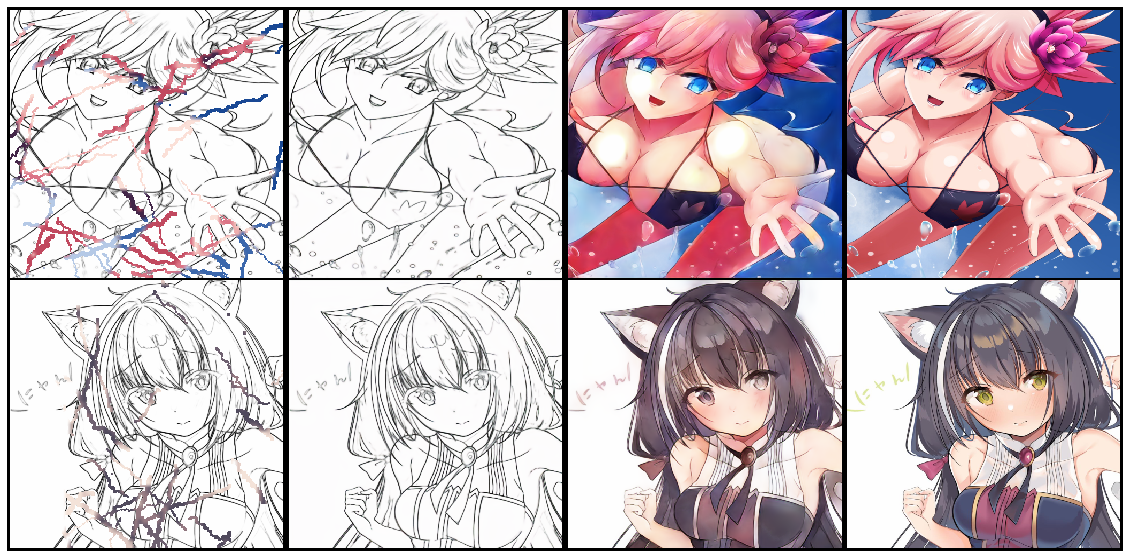


Saving... Done!
[1627/34330] Loss D_GAN: -23.91 (40.97) / GP: 0.27 / Loss_Content: 0.03 / Loss_Prec: 0.76 / Loss_Style: 0.00 / Time : 1.41 (1.86)      

In [ ]:
# Training Loop
netG.train()
netD.train()

print("Starting Training Loop...")
# For each epoch
start_epoch = current_epoch
last_epoch = epoch_num + current_epoch - 1
for epoch in range(current_epoch, epoch_num + current_epoch):
    current_epoch += 1
       
    start_time = time.time()
    total_time = 0
    running_w_list = []
    
    print('Epoch [{0}/{1}]'.format(epoch, last_epoch))
    for i, data in enumerate(train_loader, 0):                  
            
        # Set model input
        edge = data[0].to(device)
        real = data[1].to(device) 
        hint = data[2].to(device)
        empty_hint = torch.cat([edge]*3, dim=1).to(device)
        
        input_tensor = torch.cat([edge, hint], dim=1)
        empyt_hint_tensor = torch.cat([edge, empty_hint], dim=1)
        
        b_size = edge.size(0)

        ###### Discriminator ######
        netD.zero_grad()
        
        # Outputs
        fake = netG(input_tensor).detach()
        pred_fake = netD(fake, hint)
        pred_real = netD(real, hint)
    
        # GAN loss
        loss_D_GAN = pred_fake.mean() - pred_real.mean()
        
        gp = calc_gradient_penalty(netD, real, fake, hint)
        
        # Total loss
        loss_D = loss_D_GAN + gamma*gp

        # Update
        loss_D.backward()
        optimizer_D.step()
        running_w_list.append(-loss_D_GAN.item())
        
        ###################################
        
        if i % critic_iter == 0:
            ###### Generators ######
            netG.zero_grad()

            # Outputs
            fake = netG(input_tensor)
            fake_empty = netG(empyt_hint_tensor)
            pred_fake = netD(fake, hint)

            # GAN loss
            loss_G_GAN = -pred_fake.mean()

            # L1 Loss
            loss_content = (criterion_L1(fake, real) + criterion_L1(fake_empty, empty_hint))*0.5
            
            # VGG Loss
            loss_prec, loss_style = criterion_VGG(real, fake)

            # Total loss
            loss_G = 1e-2 * loss_G_GAN + 30 * loss_content + 5 * loss_prec + 0.1 * loss_style

            # Update
            loss_G.backward()
            optimizer_G.step()

            ###################################

        # Time Info.
        end_time = time.time()
        taken_time = end_time - start_time
        total_time += taken_time
        average_time = total_time / (i+1)

        # Wasserstein Distance
        w_avg = sum(running_w_list) / len(running_w_list)

        # Output training stats
        print('\r[%d/%d] Loss D_GAN: %.2f (%.2f) / GP: %.2f / Loss_Content: %.2f / Loss_Prec: %.2f / Loss_Style: %.2f / Time : %.2f (%.2f)'
              % (i+1, len(train_loader), loss_D_GAN.item(), w_avg,
                gp.item(), loss_content.item(), loss_prec, loss_style, taken_time, average_time), end='     ')
        start_time = end_time
            
        if i % 10000 == 0:
            with torch.no_grad():
                dataloader.show_example([hint, fake_empty, fake, real], (20, 5*batch_size)) 
            print()
            save('../src/model/checkpoint/temp.pth', netG, netD, current_epoch)
    
                         
    # Record loss
    loss_list_D.append(loss_D.cpu().item())
    loss_list_G.append(loss_G.cpu().item())
    w_list.append(w_avg)
        
    print()

print('Done')

# **4. Save / Load the model**

## 4.1 Save the model

Save checkpoint on `./checkpoint/edge2color/ckpt.pth`


In [26]:
print("Current epoch : {}".format(current_epoch))
save('../src/model/checkpoint/temp.pth', netG, netD, current_epoch, mode='eval')

Current epoch : 10
Saving... Done!


## 4.2 Load the model
Load checkpoint on `./checkpoint/edge2color/ckpt.pth`
To load the model weights, download the checkpoint on https://drive.google.com/open?id=1pIZCjubtyOUr7AXtGQMvzcbKczJ9CtQG (449MB) and unzip.

In [21]:
def load(netG, netD):
    global current_epoch, best_losses, loss_list_D, loss_list_G, optimizer_G, optimizer_D
    print('Loading...', end=' ')
    checkpoint = torch.load('../src/model/checkpoint/temp.pth')
    current_epoch = checkpoint['epoch']
    netG.load_state_dict(checkpoint['netG'], strict=True)
    netD.load_state_dict(checkpoint['netD'], strict=True)
    loss_list_D = checkpoint['loss_list_D'],
    loss_list_G = checkpoint['loss_list_G'],
    optimizer_G.load_state_dict(checkpoint['optimizer_G']),
    optimizer_D.load_state_dict(checkpoint['optimizer_D']),
    print("Done!")

In [22]:
load(netG, netD)
loss_list_D = loss_list_D[0]
loss_list_G = loss_list_G[0]

Loading... Done!
